## Percolating Edges of the Network and structural results

In [8]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing

import nngt
import nest
import nngt.simulation as ns
from pathlib import Path

from modules import simulation as nsim
from modules import percolation as per
from modules import analysis

from importlib import reload
#reload(nsim)
#reload(per)
#reload(analysis)

In [51]:
num_omp = multiprocessing.cpu_count() #Number of cores on the system

# network Parameters
w = 100.
ds = 0.01
do = 2.
deg = 50.
N = 500
l = 50.
R = 1000

from fromMallory.Neurons_Parameters import di_RS

params = di_RS
params['nb_neurons'] = N
print(params)

{'V_peak': 30.0, 'V_reset': -48.0, 'V_m': -51.0, 'a': 2.0, 'I_e': 262.0, 'tau_syn_ex': 0.2, 'E_L': -70.0, 'b': 70.0, 't_ref': 2.0, 'V_th': -50.0, 'w': 37.0, 'tau_w': 300.0, 'nb_neurons': 500, 'C_m': 200.0, 'Delta_T': 1.8, 'g_L': 12.01}


Making Network


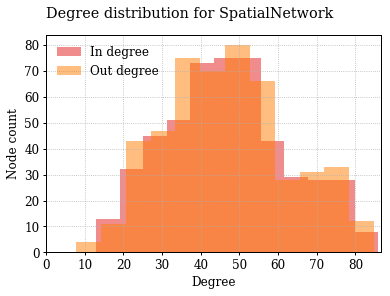

In [52]:
# Make the network
net = nsim.Make_Network("data/first_network.el", num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=True, plot_delays=False)

In [53]:
# Simulate
senders , spikes, recorder,recorded, vms, vms_time = nsim.Simulation("data/first_network.el", num_omp= num_omp,\
                                    sim_time = 15000, noise_rate = 100., noise_weight_fraction = 0.5,\
                                   noise = 'Minis', save_spk = "data/spk", show_activity = False, return_activity = True,\
                                   animation = False, anim_name = "data/anim.mp4",from_file=True)

Start Simulation
Simulation done


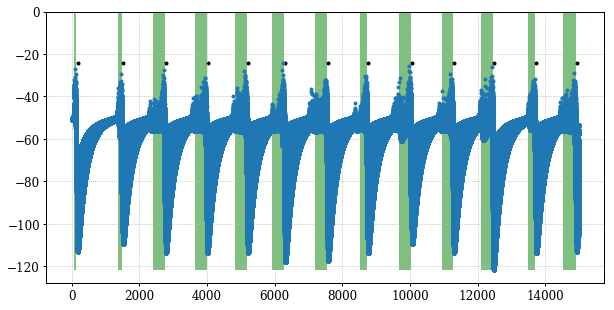

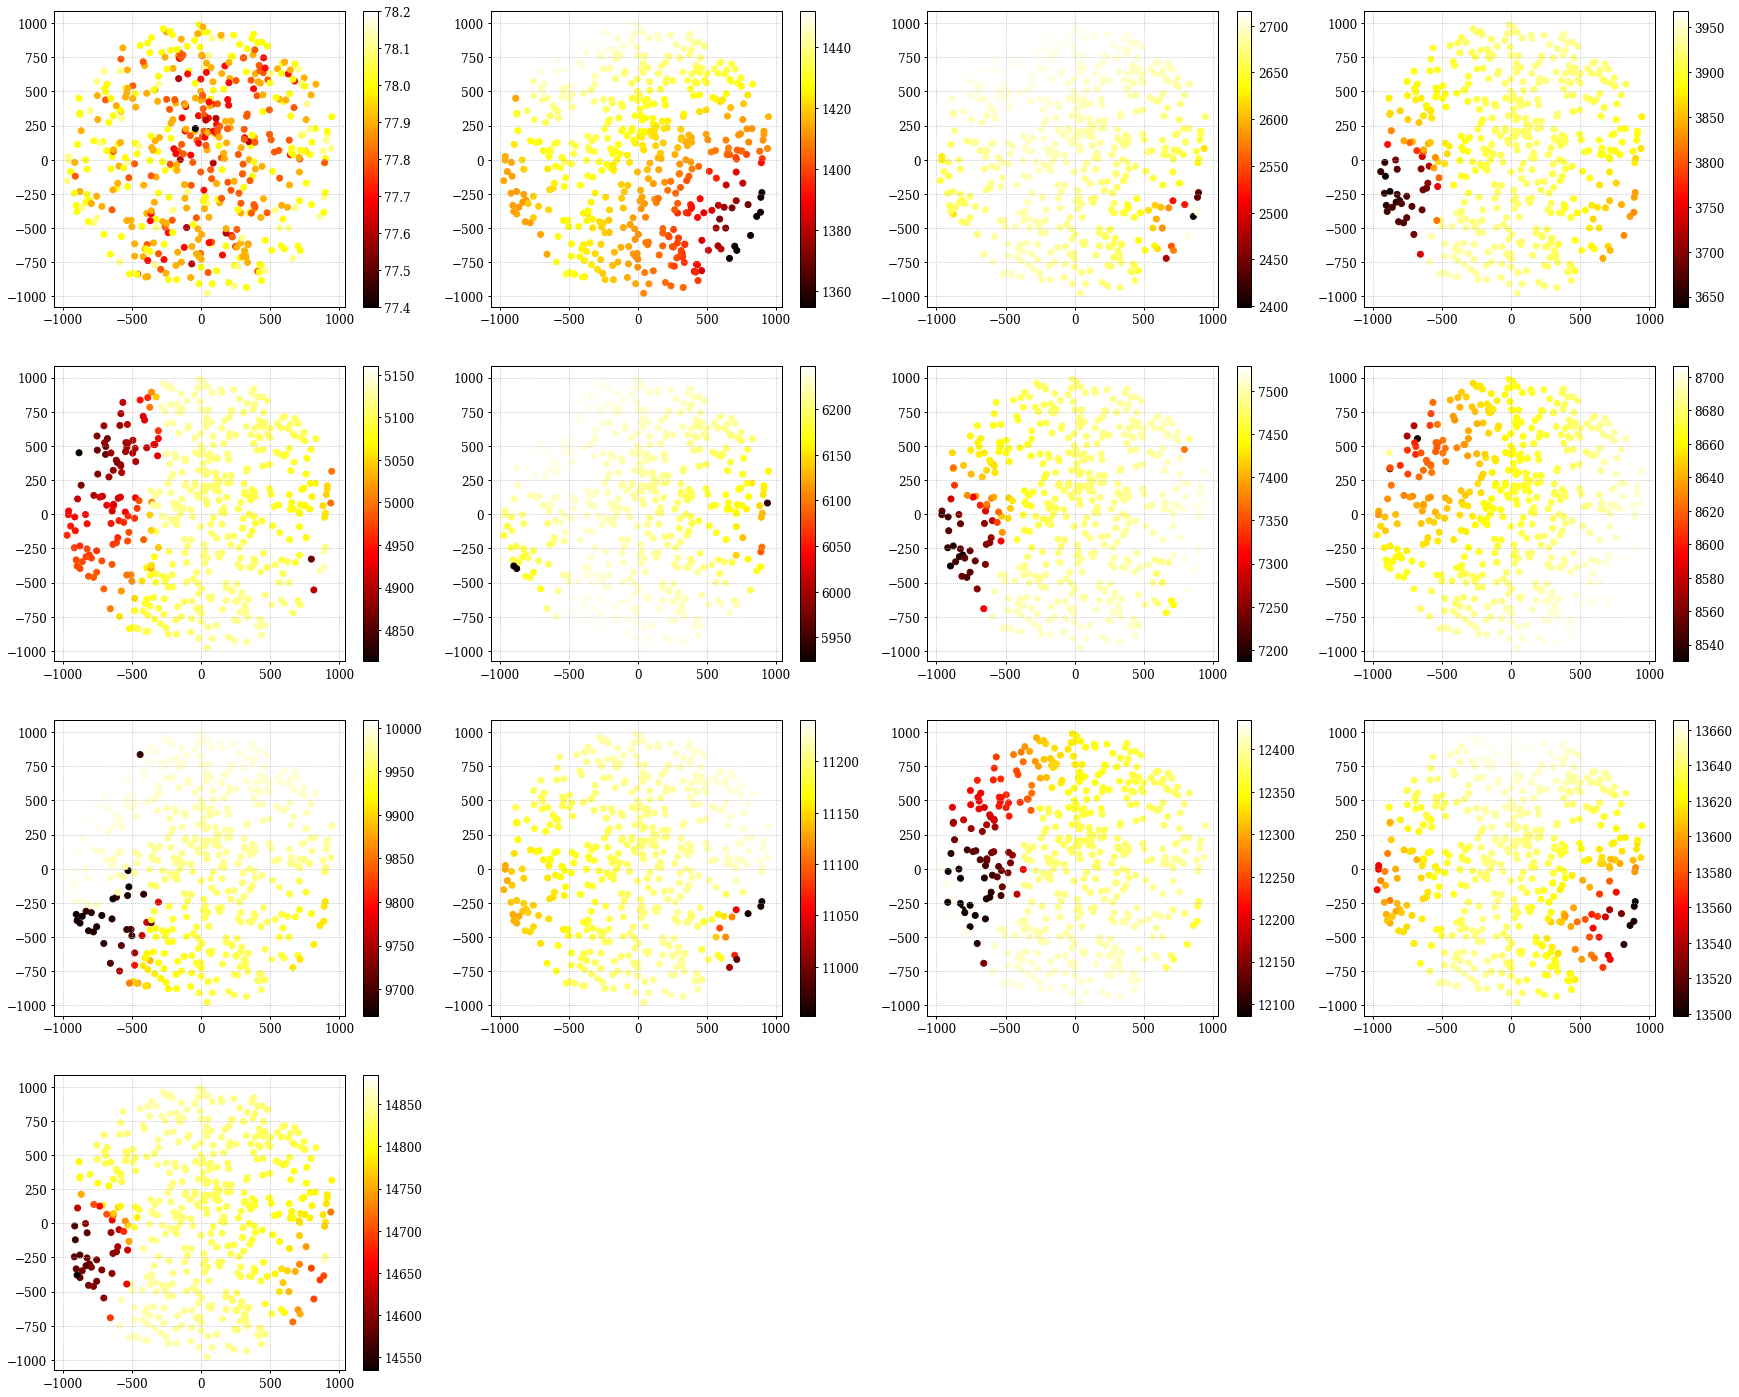

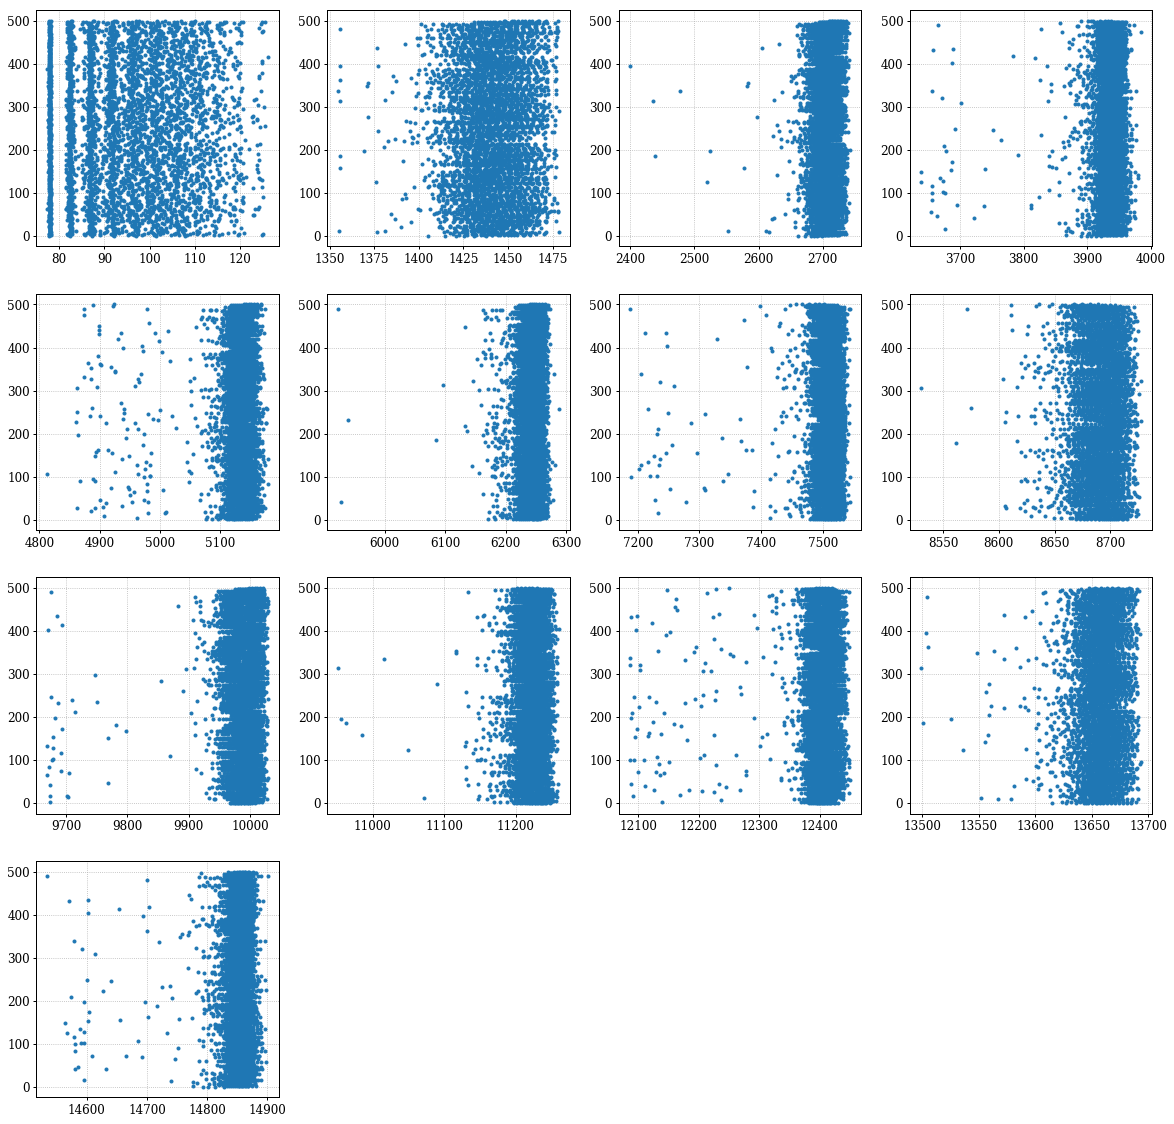

In [54]:
reload(analysis)
z,q = analysis.getBursts(net=net, spikes=spikes, senders=senders, num_neurons=N, vms_time=vms_time,\
                         vms=vms, sim_time=15000, interburst_time=800, plot_overlay=True, plot_bursts=True, plot_rasters=True)

In [74]:
def percolation_netw_statistics(net, method_removal='uniform', spacing=0.002, lspac=250, starting=0.8, plot_ssc=True, plot_gc=True):

    scc        = np.ones((lspac))
    frac       = np.zeros((lspac))
    deg        = np.zeros((lspac))
    gc         = np.zeros((lspac))
    num_connec = len((np.asarray(net.edges())))
    
    frac[0] = starting
    per.percolationEdges(net, num_remove=int(frac[0]*num_connec))
    
    deg[0]  = np.mean(net.degree_list(deg_type='in'))
    scc[0]  = nngt.analysis.num_scc(net)
    frac[0] = 1. - np.float64(len((np.asarray(net.edges()))))/num_connec
    gc[0]   = (max(nx.strongly_connected_component_subgraphs(net), key=len)).number_of_nodes()
    
    for i in range(1,lspac):

        if len(net.edges()) > 1:
            per.percolationEdges(net,num_remove=int(spacing*num_connec),method_removal=method_removal)
            if len(net.edges()) > 1:
                frac[i] =  1. - np.float64(len((np.asarray(net.edges()))))/num_connec
            else:
                frac[i] = 1.
                
            deg[i] = np.mean(net.degree_list(deg_type='in'))
            scc[i] = nngt.analysis.num_scc(net)
            gc[i]  = (max(nx.connected_component_subgraphs(net.to_undirected()), key=len)).number_of_nodes()
        
        else:
            ending = i
            break
    
    if plot_ssc:
        if plot_gc:
            fig, ax = plt.subplots(2,1)
            ax1 = ax[0]
        else:
            fig, ax1 = plt.subplots()
        fig.set_size_inches(15,10)
        ax2 = ax1.twinx()
        ax1.plot(frac[0:ending], scc[0:ending], 'g.')
        ax2.plot(frac[0:ending], deg[0:ending], 'b.')
        #ax1.hlines(y=1.,xmin=frac[0],xmax=max(frac),linestyles='dashed',label='1')
        ax1.set_xlabel('Fraction of original edges removed')
        ax1.set_ylabel('Number of Strongly connected components', color='g')
        ax2.set_ylabel('Average in-Degree', color='b')
        #ax1.legend(['Num of Strongly connected components','Average in-Degree'])
    
    if plot_gc:
        if plot_ssc:
            ax3 = ax[1] 
        else:
            fig, ax3 = plt.subplots()
            fig.set_size_inches(15,10)
      
        ax4 = ax3.twinx()
        ax3.plot(frac[0:ending], gc[0:ending], 'g.')
        ax4.plot(frac[0:ending], deg[0:ending], 'b.')
        #ax3.hlines(y=1.,xmin=frac[0],xmax=max(frac),linestyles='dashed',label='1')
        ax3.set_xlabel('Fraction of original edges removed')
        ax3.set_ylabel('Size of the Giant Component', color='g')
        ax4.set_ylabel('Average in-Degree', color='b')
        #ax3.legend(['Size of the Giant Component','Average in-Degree'])
        fig.suptitle('Removing connections with method = ' + method_removal)
        
        plt.show()
        
    return frac,scc,deg,ending,gc

Making Network


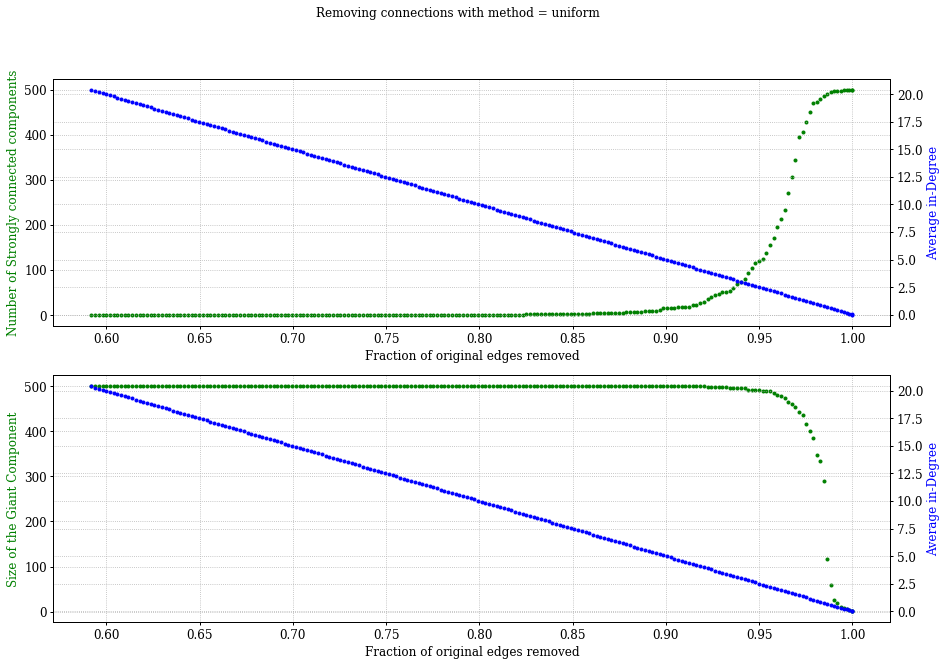

In [75]:
params['nb_neurons'] = N
net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
_ = percolation_netw_statistics(net, method_removal='uniform', spacing=0.002, lspac=250, starting=0.9, plot_ssc=True, plot_gc=True)

Making Network


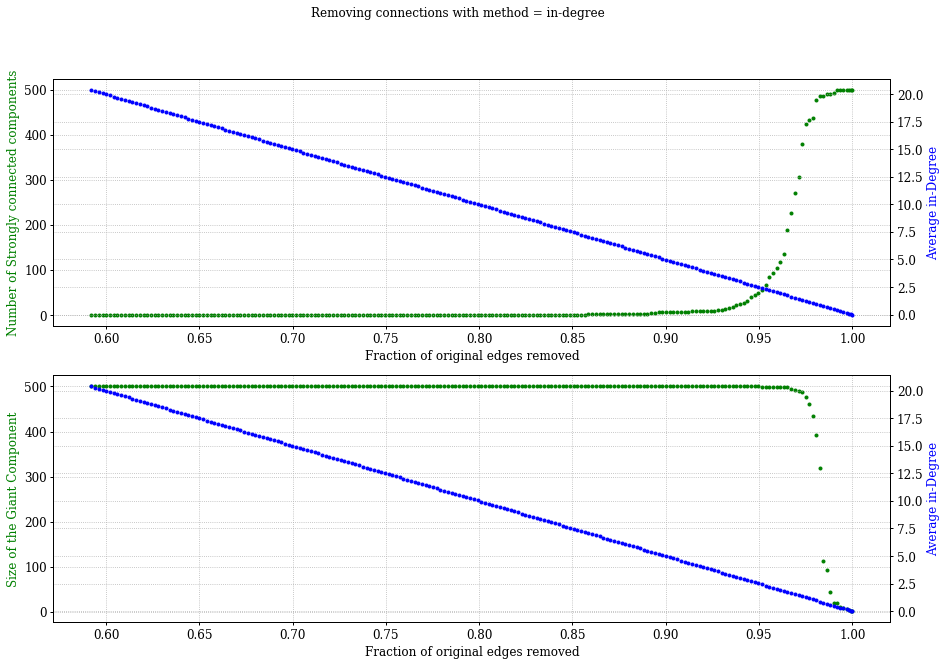

In [76]:
params['nb_neurons'] = N
net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
_ = percolation_netw_statistics(net, method_removal='in-degree', spacing=0.002, lspac=250, starting=0.9, plot_ssc=True, plot_gc=True)

Making Network


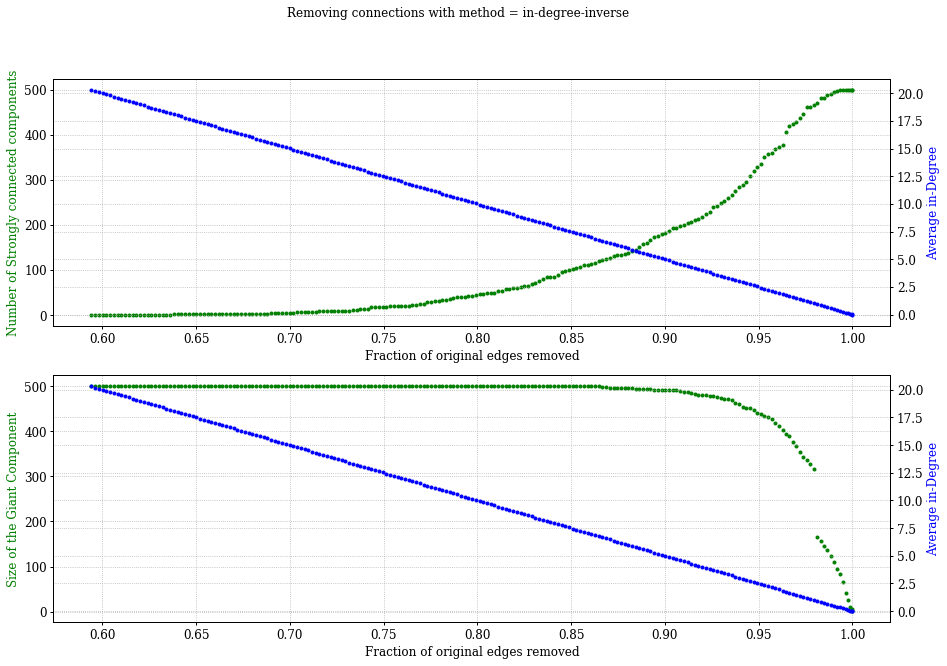

In [77]:
params['nb_neurons'] = N
net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
_ = percolation_netw_statistics(net, method_removal='in-degree-inverse', spacing=0.002, lspac=250, starting=0.9, plot_ssc=True, plot_gc=True)

Making Network


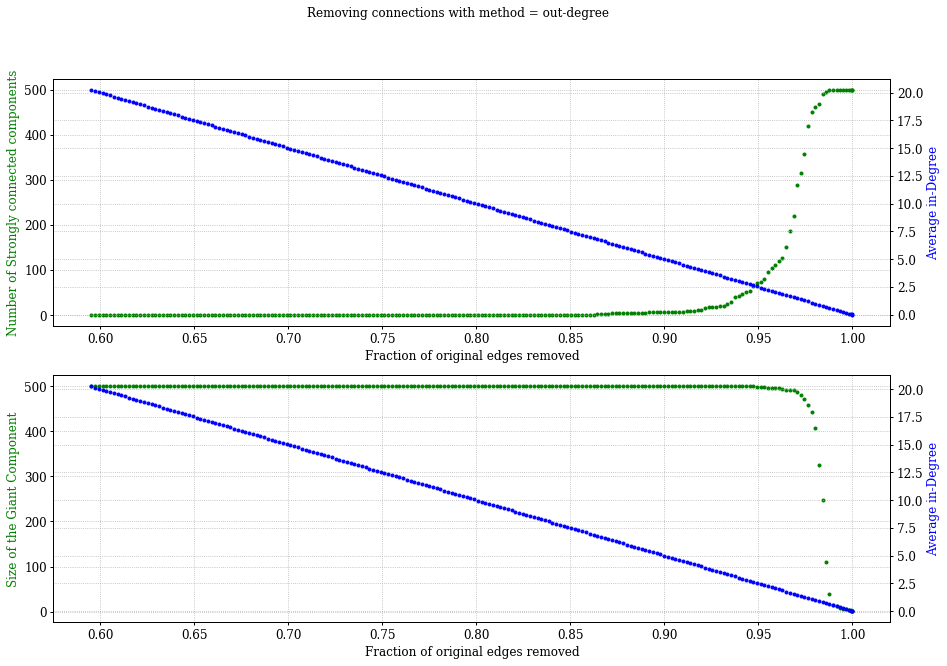

In [78]:
params['nb_neurons'] = N
net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
_ = percolation_netw_statistics(net, method_removal='out-degree', spacing=0.002, lspac=250, starting=0.9, plot_ssc=True, plot_gc=True)

Making Network


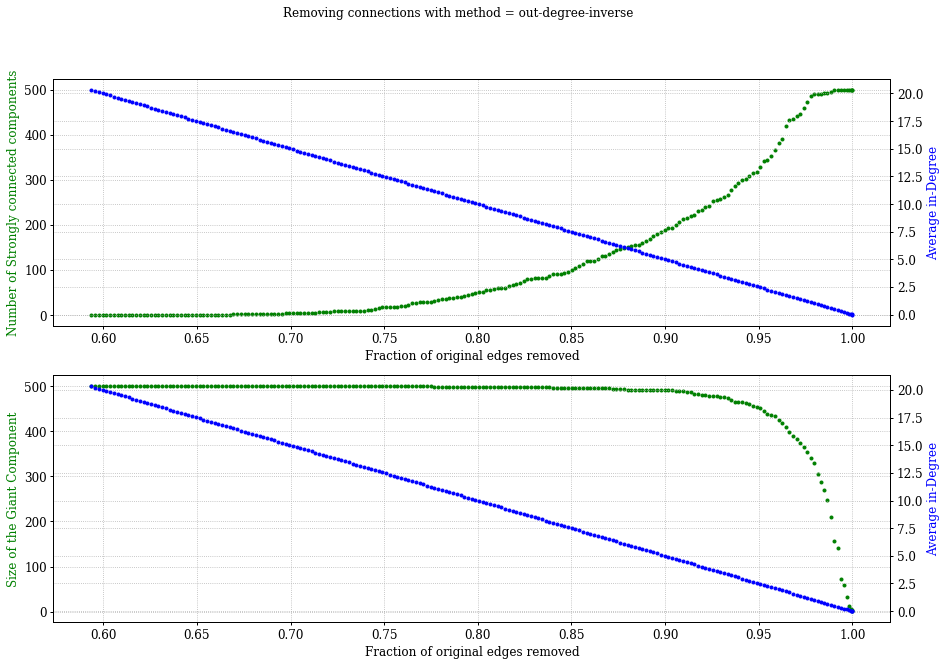

In [79]:
params['nb_neurons'] = N
net = nsim.Make_Network(None, num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = l, delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
_ = percolation_netw_statistics(net, method_removal='out-degree-inverse', spacing=0.002, lspac=250, starting=0.9, plot_ssc=True, plot_gc=True)

## Variation with $ \lambda $ (the expontial probability scale)

### Result: Does not depend on $\lambda$

Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network
Making Network


Text(0.5,1,'Number of connected components as a function of $\\lambda $')

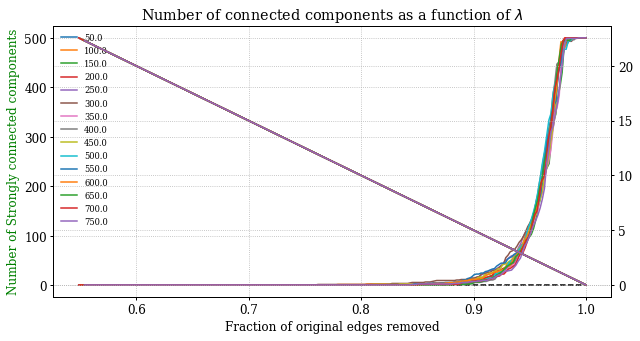

In [255]:
frac   = []
ssc    = []
degeree= []
ending = []
lamda  = np.arange(50,800,50,dtype=float)

fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)
ax2 = ax1.twinx()

for j in range(len(lamda)):
    
    w = 100.
    ds = 0.01
    do = 2.
    deg = 50.
    N = 500
    l = 50.
    R = 1000

    from fromMallory.Neurons_Parameters import di_RS

    params = di_RS
    params['nb_neurons'] = N
    
    net = nsim.Make_Network("data/first_network.el", num_omp = num_omp, culture_radius = R, num_neurons = N, \
                        avg_deg = deg, lambda_edr = lamda[j], delay_slope = ds, delay_offset = do, syn_weight = w,\
                        neuron_params = {'neuron' : params}, plot_degrees=False, plot_delays=False)
    
    a,b,c,d = connected_components(net)
    frac.append(a[0:d])
    ssc.append(b[0:d])
    degeree.append(c[0:d])
    
    ax1.plot((frac[j])[0:d], (ssc[j])[0:d], '-')
    ax2.plot((frac[j])[0:d], (degeree[j])[0:d], '-')
    
ax1.hlines(y=1.,xmin=frac[0][0],xmax=max(frac[0]),linestyles='dashed',label='1')
ax1.set_xlabel('Fraction of original edges removed')
ax1.set_ylabel('Number of Strongly connected components', color='g')
ax1.legend(lamda,loc='middle left',fontsize='small')
ax1.set_title('Number of connected components as a function of $\lambda $')